In [2]:
# ! pip3 install matplotlib
# ! pip install statsmodels
# ! pip install pmdarima

In [3]:
import os
import sys
import pandas as pd
import matplotlib.pyplot as plt
from numpy.lib.stride_tricks import sliding_window_view

In [4]:
path_to_package = os.path.abspath(os.path.join('..'))
if path_to_package not in sys.path:
    sys.path.append(path_to_package)
    
from src.utils.data_model_region import Region

In [193]:
# Global Constants
# Dataset
DATA_DIR_PATH = "./../data"
DATASET_PATH = f"{DATA_DIR_PATH}/PRSA2017_Data_20130301-20170228"
DATSET_PREPROCESSED_PATH = f"{DATA_DIR_PATH}/preprocessed"

# Model 
RANDOM_STATE = 1
PAST_WINDOW = 3
FUTURE_WINDOW = 30
BATCH_SIZE = 2048*16
TEST_SIZE = 0.4
ROLLING_WINDOW = 365

DATE_COLUMNS = ['year','month','day']
POLUTION_FEATURES = ["PM2.5","PM10","SO2","NO2","CO","O3"]



def get_preprocessed_dataset_path(region:Region, base_path:str=DATSET_PREPROCESSED_PATH)->str|None:
    """Get path to pre-processed dataset

    Args:
        region (Region): Specifies the region of the dataset
        base_path (str, optional): root dir of the dataset. Defaults to DATASET_PATH.

    Raises:
        ValueError: incorrect region provided

    Returns:
        str|None: returns the datset file path for the region or raises error
    """
    if type(region) == Region:
        return f"{base_path}/{region.value}.csv"
    else:
        raise ValueError("Unkown REGION name!!!")

In [224]:
regions_df = {}

for region in Region:
    # read datset
    regions_df[region] = pd.read_csv(get_preprocessed_dataset_path(region=region), index_col=None)
    # generate date
    regions_df[region]['date'] = pd.to_datetime(regions_df[region][DATE_COLUMNS])
    regions_df[region].drop(DATE_COLUMNS, axis=1, inplace=True)
    
    regions_df[region].drop('hour', axis=1, inplace=True)
    # group by daily and average
    regions_df[region] = regions_df[region].groupby('date').mean()
    
    # # set datetime index 
    # regions_df[region] = regions_df[region].set_index('date')

    # # cal roll mean
    # regions_df[region] = regions_df[region].rolling(ROLLING_WINDOW).mean().dropna()

    # # create diff
    # regions_df[region] = regions_df[region].diff(1).dropna()

    #standardise
    regions_df[region] = (regions_df[region]-regions_df[region].mean())/regions_df[region].std()
    
    # add week info
    regions_df[region]['week'] = regions_df[region].index.to_series().dt.isocalendar().week
    regions_df[region]['month'] = regions_df[region].index.to_series().dt.month

del region

In [225]:
# display sample
regions_df[Region.AOTIZHONGXIN]

,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,WSPM,N,S,E,W,week,month
date,,,,,,,,,,,,,,,,,
2013-03-01,-1.088518,-1.298986,-0.293283,-1.309688,-0.811365,0.225453,-1.129974,1.473133,-1.627048,-0.19241,2.070210,1.807169,-1.500405,-0.892897,0.137581,9,3
2013-03-02,-0.747682,-0.888782,0.987823,0.256692,-0.428675,-0.649512,-1.201810,1.470682,-1.418073,-0.19241,-0.307234,0.398862,-0.662462,0.241035,-0.029843,9,3
2013-03-03,-0.081638,0.138363,2.256075,0.765987,0.340777,-0.921937,-0.742987,0.270483,-1.148638,-0.19241,-0.067257,1.181255,-1.165228,-0.244936,-0.029843,9,3
2013-03-04,-0.863698,-0.856053,0.288096,-0.458356,-0.650985,-0.034152,-0.335530,0.568694,-1.101510,-0.19241,0.931716,-0.070574,0.510657,-1.216878,0.137581,10,3
2013-03-05,0.956502,0.966407,3.931367,2.607742,1.053779,0.342969,-0.675786,-0.093090,-0.792079,-0.19241,-0.776025,1.181255,-0.830051,0.727007,-1.034389,10,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-02-24,-0.880530,-1.012607,-0.042632,-0.020163,-0.670344,-0.110004,-0.780064,0.898361,-1.061204,-0.19241,-0.150970,1.024776,-1.165228,-0.730907,0.974702,8,2
2017-02-25,-1.029608,-1.181707,-0.548219,-0.570913,-0.819424,0.276733,-0.587342,0.682668,-1.032369,-0.19241,0.155977,0.868298,-0.830051,-1.702849,1.811823,8,2
2017-02-26,-0.785552,-0.906783,-0.376833,0.210796,-0.529323,-0.165557,-0.590818,0.832183,-0.846648,-0.19241,-0.190036,0.085905,0.175480,-0.082945,0.137581,8,2


In [226]:
regions_df[Region.AOTIZHONGXIN][POLUTION_FEATURES].describe()

,PM2.5,PM10,SO2,NO2,CO,O3
count,1.461000e+03,1.461000e+03,1.461000e+03,1.461000e+03,1.461000e+03,1.461000e+03
mean,5.690178e-16,2.276071e-15,3.112576e-16,-1.274211e-15,-2.626236e-16,1.673010e-15
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.114916e+00,-1.338260e+00,-9.365633e-01,-1.869321e+00,-1.073262e+00,-1.808320e+00
25%,-7.146199e-01,-7.496838e-01,-6.596192e-01,-6.967566e-01,-6.263251e-01,-8.311288e-01
50%,-2.721935e-01,-2.276562e-01,-3.618371e-01,-1.652535e-01,-3.157771e-01,-1.133378e-01
75%,3.950529e-01,4.694716e-01,2.187308e-01,5.098592e-01,2.279197e-01,6.250095e-01
max,6.199496e+00,5.706658e+00,6.013450e+00,4.073538e+00,6.098869e+00,3.489211e+00


<Axes: xlabel='date'>

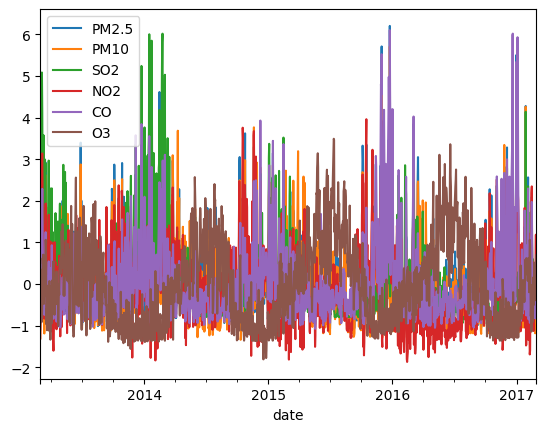

In [227]:
regions_df[Region.AOTIZHONGXIN][POLUTION_FEATURES].plot()

In [228]:
df = regions_df[Region.AOTIZHONGXIN]
feature = "PM2.5"
cols = [feature, "month", "week"]
window = PAST_WINDOW+FUTURE_WINDOW
feature_df = df[[feature]]
shift = window
for i in range(shift):
    feature_df[f'shift_{shift-i-1}'] = feature_df[feature].shift(i+1)
feature_df = feature_df.dropna()

In [229]:
feature_df

,PM2.5,shift_32,shift_31,shift_30,shift_29,shift_28,shift_27,shift_26,shift_25,shift_24,...,shift_9,shift_8,shift_7,shift_6,shift_5,shift_4,shift_3,shift_2,shift_1,shift_0
date,,,,,,,,,,,,,,,,,,,,,
2013-04-03,0.600036,0.245373,0.178048,1.322586,-0.043767,0.076458,-0.782547,0.130559,1.513142,0.283845,...,-0.696586,-0.296238,2.003658,2.608387,2.029506,0.956502,-0.863698,-0.081638,-0.747682,-1.088518
2013-04-04,-0.229514,0.600036,0.245373,0.178048,1.322586,-0.043767,0.076458,-0.782547,0.130559,1.513142,...,0.594626,-0.696586,-0.296238,2.003658,2.608387,2.029506,0.956502,-0.863698,-0.081638,-0.747682
2013-04-05,-0.402637,-0.229514,0.600036,0.245373,0.178048,1.322586,-0.043767,0.076458,-0.782547,0.130559,...,0.580199,0.594626,-0.696586,-0.296238,2.003658,2.608387,2.029506,0.956502,-0.863698,-0.081638
2013-04-06,-1.032614,-0.402637,-0.229514,0.600036,0.245373,0.178048,1.322586,-0.043767,0.076458,-0.782547,...,-0.959878,0.580199,0.594626,-0.696586,-0.296238,2.003658,2.608387,2.029506,0.956502,-0.863698
2013-04-07,-0.047975,-1.032614,-0.402637,-0.229514,0.600036,0.245373,0.178048,1.322586,-0.043767,0.076458,...,0.181654,-0.959878,0.580199,0.594626,-0.696586,-0.296238,2.003658,2.608387,2.029506,0.956502
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-02-24,-0.880530,-0.948457,-0.044368,-0.277531,-1.030795,0.384834,-0.001087,-0.900367,0.562165,2.092624,...,-0.141149,-0.826429,-0.593794,4.276503,-0.349137,1.226406,1.375202,0.070447,-0.733255,-0.842659
2017-02-25,-1.029608,-0.880530,-0.948457,-0.044368,-0.277531,-1.030795,0.384834,-0.001087,-0.900367,0.562165,...,-0.771727,-0.141149,-0.826429,-0.593794,4.276503,-0.349137,1.226406,1.375202,0.070447,-0.733255
2017-02-26,-0.785552,-1.029608,-0.880530,-0.948457,-0.044368,-0.277531,-1.030795,0.384834,-0.001087,-0.900367,...,0.028368,-0.771727,-0.141149,-0.826429,-0.593794,4.276503,-0.349137,1.226406,1.375202,0.070447


In [230]:
from torch import Tensor
from numpy import concatenate, clip
from torch.utils.data import Dataset
from numpy.lib.stride_tricks import sliding_window_view

class FeatureForcastingDataset(Dataset):
    def __init__(self, df:pd.DataFrame, pred_feature:str, past_window:int, future:int, future_window:int, model_features:list=POLUTION_FEATURES, split_date:str='2015-03-01 00:00:00', is_train:bool=True):  
        self.pred_feature = pred_feature
        self.model_features = model_features
        self.past_window = past_window
        self.future_window = future_window
        # split to train and test 
        df = df[df.index < split_date] if is_train else df[df.index >= split_date] 
        
        # normalize
        norm_feature_df = df 
        self.mean = norm_feature_df.mean()
        self.std = norm_feature_df.std()
        norm_feature_df = ( norm_feature_df - self.mean ) / self.std
        
        # build sliding window for features
        features = df[['shift_0']].to_numpy()
        
        # # build 1-hot encoding for month 
        # month_col = [f"month_{index}" for index in range(1,13)]
        # month_df = clip(sliding_window_view(df[month_col], window_shape=dataset_window, axis=0)[:,:,:-future_window].sum(axis=2),None,1)
        
        # build targets
        target = df[[f"shift_{future}"]].to_numpy()

        # build datset
        # features = concatenate([features,month_df],axis=1)
        self.features = Tensor(features)
        self.targets = Tensor(target)
        # discard variables
        del df

    def __len__(self):
        return len(self.targets)
    
    def __getitem__(self, index):
        return self.features[index], self.targets[index]
    
datset = FeatureForcastingDataset(feature_df,POLUTION_FEATURES[0],PAST_WINDOW,1, FUTURE_WINDOW,is_train=True)
datset[1]

(tensor([-0.7477]), tensor([-0.0816]))

In [231]:
import torch.nn as nn
import torch.optim as optim
import pytorch_lightning as pl
from sklearn.metrics import r2_score
from torchmetrics import R2Score, MeanAbsoluteError, MeanSquaredError

class FeatureForecastingModel(pl.LightningModule):
    def __init__(self, model_features:list=POLUTION_FEATURES, past_window:int=1, future_window:int=1, hidden_layer_size:int=2048, hidden_layers:int=3):
        super(FeatureForecastingModel, self).__init__()
        
        # init model features
        self.past_window = past_window
        self.future_window = future_window
        self.hidden_layers = hidden_layers
        self.hidden_layer_size = hidden_layer_size

        layer_list = []

        # building input layer
        layer_list.append(nn.Linear(in_features=(1), out_features=self.hidden_layer_size))
        layer_list.append(nn.ReLU())
        # building hidden layers
        for h_layer in range(self.hidden_layers):
            layer_list.append(nn.Linear(in_features=self.hidden_layer_size, out_features=self.hidden_layer_size))
            layer_list.append(nn.ReLU())
        # building ouput layer
        layer_list.append(nn.Linear(in_features=self.hidden_layer_size, out_features=1))

        # build model
        self.layers = nn.Sequential(*layer_list)
        
        # metics
        self.r2_score = R2Score()
        self.mae = MeanAbsoluteError()
        self.rmse = MeanSquaredError(squared=False)

    def forward(self, x):
        return self.layers(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        x = x.view(x.size(0), -1)  # Flatten the input images
        y_hat = self(x)
        loss = nn.functional.mse_loss(y_hat, y)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        x = x.view(x.size(0), -1)
        y_hat = self(x)
        loss = nn.functional.mse_loss(y_hat, y)
        self.log('val_loss', loss, on_epoch=True)
        self.r2_score(y_hat, y)
        self.log('r2_score', self.r2_score, on_epoch=True)
        self.mae(y_hat, y)
        self.log('mae', self.mae, on_epoch=True)
        self.rmse(y_hat, y)
        self.log('rmse', self.rmse, on_epoch=True)

    def configure_optimizers(self):
        return optim.SGD(self.parameters(), lr=0.01)


In [232]:
from torch.utils.data import DataLoader 
import torch 
torch.set_float32_matmul_precision('medium')

# Build Bataset
train_dataset = FeatureForcastingDataset(feature_df,feature, future=1, past_window=PAST_WINDOW,future_window=FUTURE_WINDOW, is_train=True)
val_dataset = FeatureForcastingDataset(feature_df,feature,future=1, past_window=PAST_WINDOW,future_window=FUTURE_WINDOW, is_train=False)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, num_workers=16, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, num_workers=16, pin_memory=True)

# build model
model = FeatureForecastingModel(past_window=PAST_WINDOW,future_window=FUTURE_WINDOW, hidden_layer_size=16, hidden_layers=1)
# Create PyTorch Lightning trainer
trainer = pl.Trainer(
    max_epochs=300,
    accelerator="gpu", 
    logger=False,
    enable_progress_bar=True,
    enable_checkpointing=False,
    devices=1  # Set the number of GPUs to use (change to 2, 3, etc., if available)
)
trainer.fit(model, train_dataloaders=train_loader)
trainer.validate(model, val_loader)
# model(val_dataset[:][0])

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type              | Params
-----------------------------------------------
0 | layers   | Sequential        | 321   
1 | r2_score | R2Score           | 0     
2 | mae      | MeanAbsoluteError | 0     
3 | rmse     | MeanSquaredError  | 0     
-----------------------------------------------
321       Trainable params
0         Non-trainable params
321       Total params
0.001     Total estimated model params size (MB)


Epoch 299: 100%|██████████| 1/1 [00:00<00:00,  2.87it/s]

`Trainer.fit` stopped: `max_epochs=300` reached.


Epoch 299: 100%|██████████| 1/1 [00:00<00:00,  2.86it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 113.81it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│            mae            │    0.6118387579917908     │
│         r2_score          │    0.3441145420074463     │
│           rmse            │    0.8422715663909912     │
│         val_loss          │    0.7094213962554932     │
└───────────────────────────┴───────────────────────────┘

[{'val_loss': 0.7094213962554932,
  'r2_score': 0.3441145420074463,
  'mae': 0.6118387579917908,
  'rmse': 0.8422715663909912}]

In [200]:
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [202]:
x = feature_df[[f'shift_{index}' for index in range(PAST_WINDOW)]]
lr_models = {}
for i in range(1,31):
    y = feature_df[[f"shift_{i}"]]
    lr_models[i] = LinearRegression().fit(x,y)
    print(f"step-{i} --> score: {lr_models[i].score(x,y)}  Y = {lr_models[i].coef_} X + {lr_models[i].intercept_}")

step-1 --> score: 1.0  Y = [[-1.40940285e-16  1.00000000e+00  1.11022302e-16]] X + [3.46944695e-18]
step-2 --> score: 1.0  Y = [[-1.06515392e-15  8.88178420e-16  1.00000000e+00]] X + [1.38777878e-17]
step-3 --> score: 0.9983714441068366  Y = [[ 0.19528206 -0.80685283  1.60983528]] X + [-0.00113575]
step-4 --> score: 0.9941422174704436  Y = [[ 0.29565928 -1.07733498  1.77702547]] X + [-0.00294977]
step-5 --> score: 0.9890034449300338  Y = [[ 0.34187053 -1.13522104  1.78546316]] X + [-0.00493508]
step-6 --> score: 0.9837503713030387  Y = [[ 0.30523829 -1.03950096  1.72312235]] X + [-0.00682411]
step-7 --> score: 0.978846530328245  Y = [[ 0.29658378 -1.03399737  1.72323669]] X + [-0.00853]
step-8 --> score: 0.9740224659106819  Y = [[ 0.3628536  -1.14949603  1.76960611]] X + [-0.01012546]
step-9 --> score: 0.9689529747895751  Y = [[ 0.40716843 -1.18363023  1.75648783]] X + [-0.01163094]
step-10 --> score: 0.9639196610840888  Y = [[ 0.39005715 -1.10656325  1.6935616 ]] X + [-0.01312719]
ste

In [206]:
start = feature_df.iloc[0][[f'shift_{index}' for index in range(PAST_WINDOW)]].to_list()
predictions = []
targets = []
for shift in lr_models:
    prediction = lr_models[shift].predict([[start]])[0][0]
    predictions.append(prediction)
    targets.append(feature_df.iloc[0][f'shift_{shift}']) 

for add_days in range(7):
    for shift in lr_models:
        prediction = lr_models[shift].predict([[predictions[add_days]]])[0][0]
        try:
            predictions[add_days+shift] += prediction
            predictions[add_days+shift] /= (add_days+7)
        except IndexError:
            predictions.append(prediction)
        

plot_df = pd.DataFrame(
data={
    'predict':predictions[:len(targets)],
    'y':targets,
}
)
plot_df.plot()

ValueError: Found array with dim 3. LinearRegression expected <= 2.

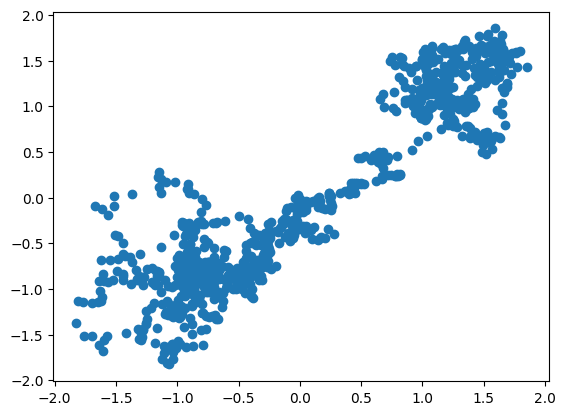

In [191]:
df = regions_df[Region.AOTIZHONGXIN]
feature = "PM2.5"
cols = [feature, "month", "week"]
window = PAST_WINDOW+FUTURE_WINDOW
window_data = sliding_window_view(df[cols], window_shape=window, axis=0).reshape(-1,len(cols)*window)
x = window_data[:,:1].reshape(-1).tolist()
month = window_data[:,window+1:window+2].reshape(-1).tolist()
week = window_data[:,-1:].reshape(-1).tolist()
y = window_data[:,FUTURE_WINDOW-0:(FUTURE_WINDOW+1-0)].reshape(-1).tolist()
plot_df = pd.DataFrame(
    data={
        'x':x,
        'y':y,
        'month':month,
        'week':week
    }
    )
plt.scatter(
    x=plot_df['x'],
    y=plot_df['y']
)

In [75]:
plot_df.to_csv("dummy.csv")

In [11]:
plot_df.corr()

,x,y,month,week
x,1.000000,0.971276,-0.189052,-0.129730
y,0.971276,1.000000,-0.132586,-0.116408
month,-0.189052,-0.132586,1.000000,0.548888
week,-0.129730,-0.116408,0.548888,1.000000


In [98]:
window_data[:,:1].reshape(1, -1)

array([[1.2419911223329827, 1.2799546174637988, 1.3347360266339379, ...,
        -0.8419027383158451, -0.678565443238349, -0.6844356450813781]],
      dtype=object)

In [132]:
regression_model = LinearRegression().fit(window_data[:,:1], window_data[:,FUTURE_WINDOW-0:(FUTURE_WINDOW+1-0)])
# make predictions
y_predicted = regression_model.predict(window_data[:,:1])
# evaluate
mae = metrics.mean_absolute_error(y, y_predicted)
rmse = metrics.mean_squared_error(y, y_predicted, squared=False)
r2 = metrics.r2_score(y, y_predicted)
# store the results
[feature, mae, rmse, r2, regression_model.score(window_data[:,:1], window_data[:,FUTURE_WINDOW-0:(FUTURE_WINDOW+1-0)])]

['PM2.5',
 0.2713446999596275,
 0.3609256211065257,
 0.8688369322620162,
 0.8688369322620162]

In [101]:
print(f"Y = {regression_model.coef_} X + {regression_model.intercept_}")

Y = [[0.91937451]] X + [-0.04148603]


In [108]:
len(y)

1067

<Axes: >

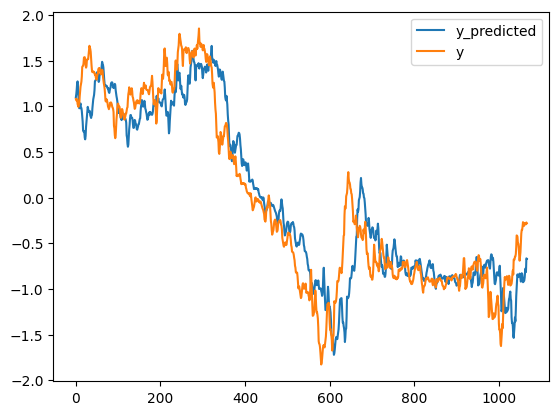

In [114]:
pred_df = pd.DataFrame(
    data={
        'y_predicted':y_predicted.flatten().tolist(),
        'y':y
    }
    )
pred_df[:].plot()

In [85]:
def train_test_split(df:pd.DataFrame, feature:str, past_window:int, future_window:int, split_date:str='2016-03-01 00:00:00'):
    train_len = len(df[df.index < split_date]) 
    dataset_window = past_window + future_window
    sliding_window_dataset = sliding_window_view(df[feature], dataset_window)
    X_train = sliding_window_dataset[:train_len, :-future_window]
    X_test = sliding_window_dataset[train_len:, :-future_window]
    y_train = sliding_window_dataset[:train_len, -1:]
    y_test = sliding_window_dataset[train_len:, -1:]
    del sliding_window_dataset
    del dataset_window
    del train_len
    return X_train, X_test, y_train, y_test 

In [86]:
evaluations = []

for feature in ['PM2.5']:
    # loop over diffrent size window
    for past_window in [1]:
        for future_window in [30]:
            # test train split
            X_train, X_test, y_train, y_test = train_test_split(regions_df[Region.AOTIZHONGXIN],feature,past_window,future_window)
            # build model
            regression_model = LinearRegression().fit(X_train, y_train)
            # make predictions
            y_predicted = regression_model.predict(X_test)
            # evaluate
            mae = metrics.mean_absolute_error(y_test, y_predicted)
            rmse = metrics.mean_squared_error(y_test, y_predicted, squared=False)
            r2 = metrics.r2_score(y_test, y_predicted)
            # store the results
            evaluation = [feature, past_window, future_window, mae, rmse, r2]
            evaluations.append(evaluation)

In [87]:
evaluations

[['PM2.5',
  1,
  30,
  0.1878936242853831,
  0.26603174737491503,
  -0.5194286974541718]]

<Axes: >

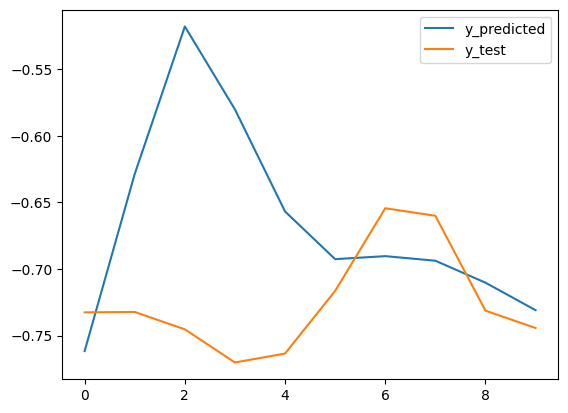

In [88]:
pred_df = pd.DataFrame(
    data={
        'y_predicted':y_predicted.flatten().tolist()[1:],
        'y_test':y_test.flatten().tolist()[:-1]
    }
    )
pred_df[:10].plot()

<Axes: >

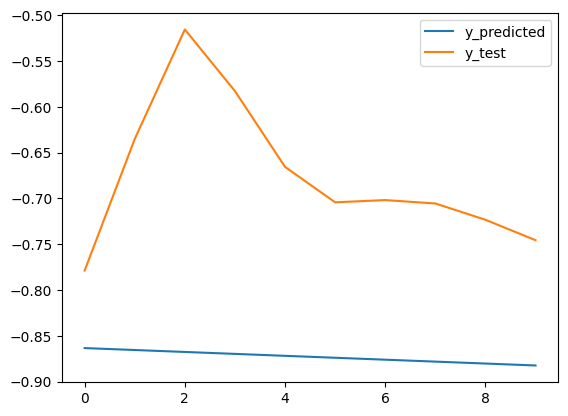

In [74]:
y_target = [y_test[0][0]]
y_pred = [regression_model.predict([X_test[0]])[0][0]]
for index in range(1,60):
    y_target.append(y_test[index][0])
    y_pred.append(regression_model.predict([[y_pred[-1]]])[0][0])

pred_df = pd.DataFrame(
    data={
        'y_predicted':y_pred,
        'y_test':y_target
    }
    )
pred_df[:10].plot()


In [76]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm

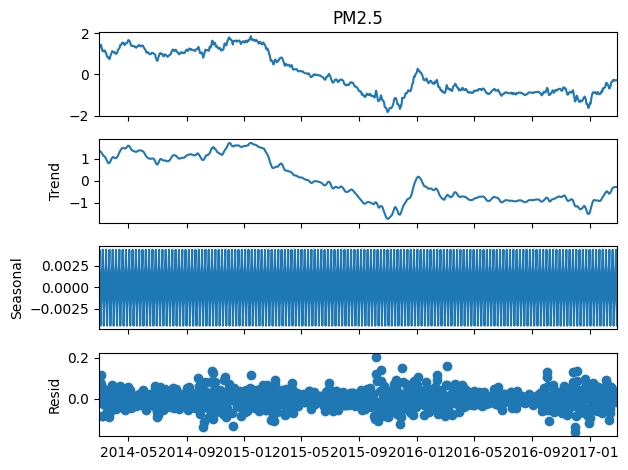

In [77]:
decompose = sm.tsa.seasonal_decompose(regions_df[Region.AOTIZHONGXIN]['PM2.5'][:24*30*12], model='aditive')
fig = decompose.plot()

(-1.545515829008263,
 0.5108873138291559,
 2,
 1094,
 {'1%': -3.436341508283391,
  '5%': -2.864185524365606,
  '10%': -2.5681785627437677},
 -3815.4927424247126)

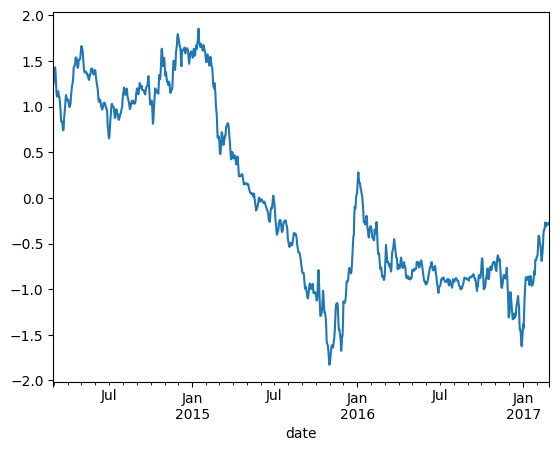

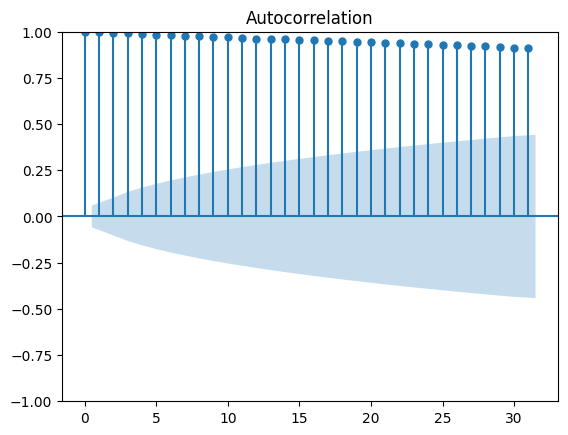

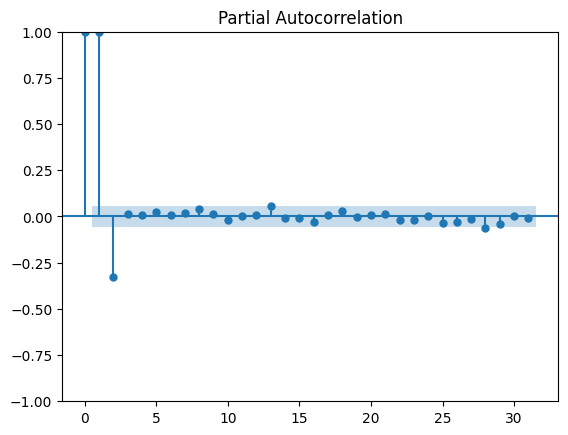

In [78]:
regions_df[Region.AOTIZHONGXIN]['PM2.5'].plot()
acf = plot_acf(regions_df[Region.AOTIZHONGXIN]['PM2.5'])
pacf = plot_pacf(regions_df[Region.AOTIZHONGXIN]['PM2.5'])
adfuller(regions_df[Region.AOTIZHONGXIN]['PM2.5'])

In [80]:
from pmdarima import auto_arima
import warnings
warnings.filterwarnings("ignore")

arima = auto_arima(regions_df[Region.AOTIZHONGXIN]['PM2.5'],trace=True,suppress_warnings=True)
arima.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-3888.647, Time=0.44 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-3521.539, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-3852.972, Time=0.14 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-3869.040, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-3522.636, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-3889.426, Time=0.33 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-3890.040, Time=0.23 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-3890.330, Time=0.29 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-3889.055, Time=0.36 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=-3890.286, Time=0.40 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=-3888.751, Time=0.44 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=-3891.960, Time=0.08 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-3891.630, Time=0.09 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=-3890.682, Time=0.05 sec
 ARIMA(0,1,4)(0,0,0

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1097
Model:               SARIMAX(0, 1, 3)   Log Likelihood                1949.980
Date:                Mon, 05 Jun 2023   AIC                          -3891.960
Time:                        07:08:26   BIC                          -3871.963
Sample:                    02-28-2014   HQIC                         -3884.394
                         - 02-28-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.6183      0.022     27.629      0.000       0.574       0.662
ma.L2          0.1792      0.027      6.636      0.000       0.126       0.232
ma.L3          0.0484      0.024      2.018      0.044       0.001       0.095
sigma2         0.0017   4.73e-05     35.262      0.000       0.002       0.002
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               349.54
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               1.02   Skew:                             0.10
Prob(H) (two-sided):                  0.82   Kurtosis:                         5.76
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<Axes: >

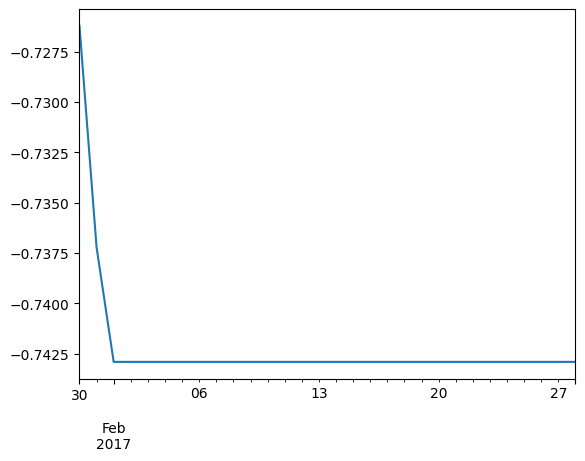

In [83]:
# split test train 
train_df = regions_df[Region.AOTIZHONGXIN]['PM2.5'].iloc[:-30]
test_df = regions_df[Region.AOTIZHONGXIN]['PM2.5'].iloc[-30:]

# build ARIMA model
model_arima = sm.tsa.arima.ARIMA(train_df,order=(0,1,3))
model_arima_fit = model_arima.fit()
model_arima_fit.summary()

# make predictions
model_arima_fit.predict(start=len(train_df), end=len(test_df)+ len(train_df)-1).plot()